In [33]:
"""WARNING"""
"""input_folder: '/Users/hanyufeng/fsdownload/BEST quality' is a folder, which stores original picture
'/Users/hanyufeng/fsdownload/BEST quality/processed' is a folder, which stores processed picture. 
Since I write the code step by step, the picture which PADIM needed, will appear after the third step.
"""

"input_folder: '/Users/hanyufeng/fsdownload/BEST quality' is a folder, which stores original picture\n'/Users/hanyufeng/fsdownload/BEST quality/processed' is a folder, which stores processed picture. \nSince I write the code step by step, the picture which PADIM needed, will appear after the third step."

In [23]:
#FIRST
#Since some of size of picture is 1440*1440, it will cause some error in next step(process picture). 
#In this step, I will make the size of all picture to be 1200*1200. 
import cv2
import numpy as np
import os

input_folder = '/Users/hanyufeng/fsdownload/BEST quality/train'
output_folder = '/Users/hanyufeng/fsdownload/BEST quality/finally'

def resize_image(image, new_size):
    # Resize the image
    resized_image = cv2.resize(image, new_size)
    return resized_image

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get a list of all image files in the input folder
image_files = [f for f in os.listdir(input_folder) if f.endswith((".jpeg", ".png"))]

# Iterate through each image file
for image_file in image_files:
    input_path = os.path.join(input_folder, image_file)
    # Read the image
    image = cv2.imread(input_path)
    #width,height,chanel
    height, width, chanel = image.shape
    if (height, width) != (1200, 1200):
        new_size = (1200, 1200)
        image = resize_image(image, new_size)
         # Construct the output image file path
    output_path = os.path.join(output_folder, image_file)
    # Save the processed image to the output folder
    cv2.imwrite(output_path, image)

In [7]:
#SECOND
#In this step, I will change all diamond to same size(radius and center)
'''
A) apply a threshold to detect the black background (30?) : all pixels above a threshold are in the diamond
    to compute the right threshold, compute the mean of values in pixels in squares in the four corners of the image. Compute also the std of these values, 
    then the right threshold is this mean 3 or 5 times the std
B) verify all pixels above the threshold are in the diamond
C) Compute the center of diamond as the barycenter of pixels in the diamond 
D) Compute the radius as the square root of the number of pixels  divided by \pi
E) Zoom in (or out) the diamond image and translate so that all diamonds have same center and same radius
'''
import cv2
import numpy as np
import os
#Since the file names are the same, the newly generated file will automatically overwrite the old file.
#so there is no need to delete the unprocessed file.
input_folder = '/Users/hanyufeng/fsdownload/BEST quality/finally'
output_folder = '/Users/hanyufeng/fsdownload/BEST quality/finally'

def detect_diamond(image, threshold):
    # Create a mask image of the same size as the input image
    mask = np.zeros_like(image, dtype=np.uint8)
    
    # Set all pixels above the threshold to white
    mask[image > threshold] = 255
    
    return mask

def compute_barycenter(mask):
    # Find the coordinates of the white pixels
    white_pixels = np.where(mask == 255)
    
    # Calculate the centroid of the white pixels
    center_x = np.mean(white_pixels[1])
    center_y = np.mean(white_pixels[0])
    
    return center_x, center_y

def compute_radius(mask):
    # Count the number of white pixels
    white_pixel_count = np.sum(mask == 255)
    
    # Calculate the radius
    radius = np.sqrt(white_pixel_count / np.pi)
    
    return radius

def zoom_and_translate(image, diamond_center, diamond_radius, new_center, new_radius):
    diamond_center = (int(diamond_center[0]), int(diamond_center[1]))
    diamond_radius = int(diamond_radius)
    # Calculate scaling factor
    scale = new_radius / diamond_radius

    # Calculate translation vector
    tx = new_center[0] - diamond_center[0] * scale
    ty = new_center[1] - diamond_center[1] * scale

    # Create affine transformation matrix
    M = np.array([[scale, 0, tx],
                  [0, scale, ty]], dtype=np.float32)

    # Apply affine transformation to the diamond region only
    diamond_mask = np.zeros_like(image, dtype=np.uint8)
    cv2.circle(diamond_mask, diamond_center, diamond_radius, (255, 255, 255), -1)
    warped_diamond = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    warped_diamond = cv2.bitwise_and(warped_diamond, diamond_mask)

    # Create black background
    background = np.zeros((1200, 1200, 3), dtype=np.uint8)

    # Calculate position to place the warped image in the center of the background
    x_offset = (background.shape[1] - warped_diamond.shape[1]) // 2
    y_offset = (background.shape[0] - warped_diamond.shape[0]) // 2

    # Place the warped image on the black background
    background[y_offset:y_offset+warped_diamond.shape[0], x_offset:x_offset+warped_diamond.shape[1]] = warped_diamond

    return background

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get a list of all image files in the input folder
image_files = [f for f in os.listdir(input_folder) if f.endswith((".jpeg", ".png"))]

# Iterate through each image file
for image_file in image_files:
    # Construct the full path of the input image file
    input_path = os.path.join(input_folder, image_file)

    # Read the image
    image = cv2.imread(input_path)  # Read as a color image

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get the mean and standard deviation of the four corner pixels
    corner_pixels = [gray_image[0, 0], gray_image[0, -1], gray_image[-1, 0], gray_image[-1, -1]]
    mean_val = np.mean(corner_pixels)
    std_val = np.std(corner_pixels)

    # Calculate the threshold
    threshold = mean_val * 3  # or threshold = mean_val * 5

    # Check if all pixels above the threshold are within the diamond
    mask = detect_diamond(gray_image, threshold)

    # Calculate the centroid of the diamond
    center_x, center_y = compute_barycenter(mask)

    # Calculate the radius of the diamond
    radius = compute_radius(mask)

    # Zoom and translate the diamond image
    new_center = (600, 600)  # New center position
    new_radius = 423.0  # New radius
    zoomed_image = zoom_and_translate(image, (center_x, center_y), radius, new_center, new_radius)

    # Construct the full path of the output image file
    output_path = os.path.join(output_folder, image_file)

    # Save the processed image to the output folder
    cv2.imwrite(output_path, zoomed_image)

In [13]:
#THIRD center crop
from PIL import Image
import os

# Set the input and output directories
input_dir = '/Users/hanyufeng/fsdownload/BEST quality/VVS1_process/classified_images/Cluster_1_ground'
output_dir = '/Users/hanyufeng/fsdownload/BEST quality/VVS1_process/classified_images/Cluster_1_ground'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate through all the files in the input directory
for filename in os.listdir(input_dir):
    # Check if the file is an image file
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        # Construct the full path of the input and output files
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        
        # Open the image
        with Image.open(input_path) as img:
            # Get the width and height of the image
            width, height = img.size
            
            # Calculate the coordinates for a 600x600 crop centered on the image
            left = (width - 256) // 2
            top = (height - 256) // 2
            right = left + 256
            bottom = top + 256
            
            # Crop the image to the 600x600 centered region
            cropped_img = img.crop((left, top, right, bottom))
            
            # Save the cropped image to the output directory
            cropped_img.save(output_path)

In [15]:
#Fourth 
#histogram equalization  
'''Due to the shooting angle and lighting position of diamonds, 
different diamonds will have different brightness in the same area. 
In order to eliminate this difference, we use histogram equalization 
to improve the accuracy of our PaDim detection.'''
import cv2
import numpy as np
import os

# Set input and output folder paths
input_folder = '/Users/hanyufeng/fsdownload/BEST quality/VVS1'
output_folder = '/Users/hanyufeng/fsdownload/BEST quality/VVS1_he'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through all images in the input folder
for filename in os.listdir(input_folder):
    # Construct the full path of the current image
    if filename[-1] == '.png':
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        # Read the image
        img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        # Perform histogram equalization
        equalized_img = cv2.equalizeHist(img)

        # Save the processed image
        cv2.imwrite(output_path, equalized_img)

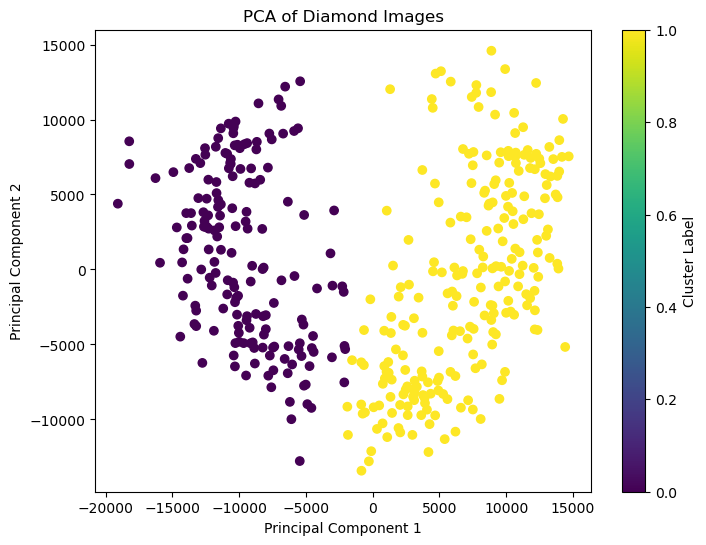

Images classified into /Users/hanyufeng/fsdownload/BEST quality/finally_process/classified_images/Cluster_0 and /Users/hanyufeng/fsdownload/BEST quality/finally_process/classified_images/Cluster_1.


In [14]:
#fifth
#PCA and kmeans
'''Among the best quality diamonds, the variability of diamonds is very large, 
which leads to inaccuracy in our training process. We used PCA and k-means algorithms to 
classify our dataset into two groups to increase the accuracy of our test data.
PCA reduces the dimension of the data, and k-means classifies the reduced-dimensional data.'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os

# Set the image directory
image_dir = '/Users/hanyufeng/fsdownload/BEST quality/finally_process'  # Replace with your image directory
output_dir = os.path.join(image_dir, 'classified_images')
os.makedirs(output_dir, exist_ok=True)  # Create output directory

# Create classification folders
cluster_0_dir = os.path.join(output_dir, 'Cluster_0')
cluster_1_dir = os.path.join(output_dir, 'Cluster_1')
os.makedirs(cluster_0_dir, exist_ok=True)
os.makedirs(cluster_1_dir, exist_ok=True)

# Read and process images
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
images = []
for file in image_files:
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_flattened = img.flatten()
    images.append(img_flattened)

# Convert to NumPy array
data = np.array(images)

# Use PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 principal components
data_pca = pca.fit_transform(data)

# Use K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(data_pca)

# Save classification results
for i, label in enumerate(labels):
    if label == 0:
        cv2.imwrite(os.path.join(cluster_0_dir, image_files[i]), cv2.imread(os.path.join(image_dir, image_files[i])))
    else:
        cv2.imwrite(os.path.join(cluster_1_dir, image_files[i]), cv2.imread(os.path.join(image_dir, image_files[i])))

# Visualize results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')
plt.title('PCA of Diamond Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

print(f'Images classified into {cluster_0_dir} and {cluster_1_dir}.')

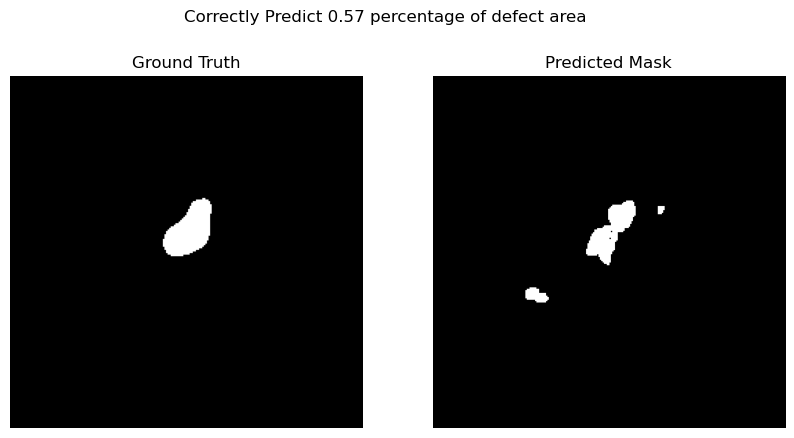

(0.5651828298887123, 209)


In [21]:
#sixth
#Intersection over Union(IOU)
#To evaluate the results on our data, we will use the IOU algorithm.
from PIL import Image
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import os

def calculate_iou(image_path1, image_path2):
    # Load and convert the images to binary
    image1 = Image.open(image_path1).convert('L')
    image2 = Image.open(image_path2).convert('L')

    image1_array = np.array(image1)
    image2_array = np.array(image2)

    # Convert images to binary
    image1_binary = np.where(image1_array > 0, 1, 0)
    image2_binary = np.where(image2_array > 0, 1, 0)

    # Ensure both images are the same size (256x256)
    image2_resized_binary = resize(image2_binary, (256, 256), anti_aliasing=True)
    image2_resized_binary = np.where(image2_resized_binary > 0, 1, 0)
    image1_resized_binary = resize(image1_binary, (256, 256), anti_aliasing=True)
    image1_resized_binary = np.where(image1_resized_binary > 0, 1, 0)

    # Calculate IoU
    intersection = np.logical_and(image1_resized_binary, image2_resized_binary)
    union = np.logical_or(image1_resized_binary, image2_resized_binary)

    # IoU calculation
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0

    # False Positive calculation
    FP = np.sum(image2_resized_binary) - np.sum(intersection)

    # Plotting the results
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plt.suptitle(f'Correctly Predict {iou:.2f} percentage of defect area')
    axes[0].imshow(image1_binary, cmap='gray')
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')

    axes[1].imshow(image2_resized_binary, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    plt.show()

    return iou, FP

input_dir = '/Users/hanyufeng/fsdownload/BEST quality/s/WechatIMG9771.jpg'
input_dir2 = '/Users/hanyufeng/fsdownload/BEST quality/s/WechatIMG9772.jpg'

# Calculate IoU
iou_result = calculate_iou(input_dir, input_dir2)
print(iou_result)